# TSV Maker for the spatial mapping housing characteristics

**Contributors:** Anthony D. Fontanini

**Date Created:** December 11th, 2019
    
This notebook restructures the spatial description of the housing characteristics samples. Currently there are only two spatial descriptions in the housing characteristics: 1) Location (the ewp weather file regions), and 2) Location Region (RECS defined Custom Regions) The notebook creates 10 housing characteristic files that help spatially define the location of a sampled housing unit.

1. ASHRAE 169 and IECC Climate Zone.tsv
2. State.tsv
3. County.tsv
4. PUMA.tsv
5. Census Division
6. Census Region.tsv.tsv
7. Location Region.tsv
8. Building America Climate Zone.tsv
9. Location
10. ISO RTO Region.tsv

# Import modules

In [1]:
import os
import sys
import plotly
import random
import numpy as np
import pandas as pd
import colorlover as cl
from tsv_maker import TSVMaker # Class with methods to create the spatial tsvs
import matplotlib.pyplot as plt
import plotly.figure_factory as ff
from math import sin, cos, sqrt, atan2, radians

# Function definitions
The all function definitions are in the TSVMaker class, but a plotting function defined here to clean up the code blocks below.

In [2]:
def histogram_plot(df,env):
    """Plotting histogram function for the plots below."""
    # Sort the values
    df.sort_values(env['counts'],ascending=False,inplace=True)

    # Plot Distribution
    plt.rcParams.update({'font.size': 16})    
    fig,ax = plt.subplots(figsize=env['figsize'])
    plt.subplots_adjust(bottom=env['bottom_pad'])
    plt.rcParams.update({'font.size': 16})
    
    ax.bar(df[env['x_variable']],df[env['counts']]/df[env['counts']].sum())
    ax.set_ylim([0,env['y_max']])
    ax.set_xlim([-1,len(df)])
    ax.set_ylabel('Probability')
    ax.set_xlabel('')
    ax.set_title(env['title'])
    ax.set_xticklabels(df[env['x_variable']],ha='right',rotation=45,fontsize=env['xlabel_fontsize'])
    
    # Write plot image
    ## Path to image
    image_path = os.path.join('images','%s_distribution.svg' % env['x_variable'])
    
    ## Make directory if it does not exist
    try:
        os.stat('images')
    except:
        os.mkdir('images')   
    
    ## Save figure
    plt.savefig(image_path)
    
    # Show figure
    plt.show()

# Inputs
Some inputs for this notebook.
- `write_tf (bool)`: Flag to write the created tsv files
- `projects (list(str))`: A list of string with the projects to copy the newly created characteristics. This input does not matter if `write_tf=False`.
- `buildstockdb_path (string)`: Path to the local clone of buildstockdb

In [3]:
write_tf = True
projects = ['project_multifamily_beta']
buildstockdb_path = os.path.join('..','..','..','buildstockdb')

# Data Used

### Other repositories
This analysis uses data from two other repositories.

1. https://github.com/kjhealy/fips-codes
2. https://gist.github.com/philngo/d3e251040569dba67942

From (1), the county_fips_master.csv file is used. From (2) the climate_zones.csv file is used. Download these files into this directory. Some modifications have been made to the 2nd data source.  The moisture regimes did not seem to match https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf.

### Survey data

1. American Community Survey (ACS): 
2. Public Use Microdata Sample (PUMS): 

Please note that when using these data plese cite PUMS accordingly.

    `IPUMS USA, University of Minnesota, www.ipums.org.`

<u>Also do not distribute this data</u>. The data can be queried directly from IPUMS USA or American Fact Finder.

The data is stored in S3 in the `resbldg-datasets` bucket and the  `various_datasets` prefix. These data along will be downloaded using the TSV_Maker class.

# Initialize the tsv_maker()

The initialization of the tsv_maker object downloads data from S3 and creates a spatial lookup table with the ACS and PUMS unit counts. This table is based on census tracts, and provides a consistent dataset to aggregate the unit counts for the different geospatial resolutions. The columns of the dataframe are as follows.

## df (tract level spatial lookup table)

### Spatial fields
- **tractce** (int): 2010 tribal census tract code.
- **puma5ce** (int): 2010 Census Public Use Microdata Area (PUMA) code.
- **puma7ce** (str): 2010 Census Public Use Microdata Area (PUMA) code with state fips.
- **puma_tsv** (str): Form of "`state_abbr`, `puma5ce`". Writing leading zeros is problematic with excel.
- **geoid** (str): 2 digit state, 3 digit county, and 6 digit tract
- **fips** (int): Federal Information Processing Standards (FIPS) number.
- **county_name** (str): Name of the county.
- **state_abbr** (str): State abbreviation.
- **state_name** (str): Full state name.
- **long_name** (str): The state abbreviation and county name combined (better for organizing the counties in a list)
- **region** (int): Census Region.
- **division** (int): Census division.
- **state** (int): State by integer from FIPS.
- **county** (int): County integer in the state from FIPS.
- **region_name** (str): The name of the census region.
- **division_name** (str): The name of the census division.
- **cz_number** (int): ASHRAE 169 climate zone number.
- **cz_moisture_regime** (str): ASHRAE 169 moisture regime.
- **climate_zone** (str): ASHRAE 169 climate zone number and moisture regime
- **ba_climate_zone** (str): The Building America Climate zone
- **iso_zone** (str): Description of the ISO/RTO.
- **location** (str): The weather station location specified at the county level
- **weight** (int): A column of all 1s that is used to create the mapping tsvs only.

### Housing unit count field
- **acs_count** (int): The number of housing units according to ACS 5 year 2016.

## county_df (county level spatial lookup table)

### Spatial fields
- **fips** (int): Federal Information Processing Standards (FIPS) number.
- **county_name** (str): Name of the county.
- **state_abbr** (str): State abbreviation.
- **state_name** (str): Full state name.
- **long_name** (str): The state abbreviation and county name combined (better for organizing the counties in a list)
- **region** (int): Census Region.
- **division** (int): Census division.
- **state** (int): State by integer from FIPS.
- **county** (int): County integer in the state from FIPS.
- **region_name** (str): The name of the census region.
- **division_name** (str): The name of the census division.
- **cz_number** (int): ASHRAE 169 climate zone number.
- **cz_moisture_regime** (str): ASHRAE 169 moisture regime.
- **climate_zone** (str): ASHRAE 169 climate zone number and moisture regime
- **ba_climate_zone** (str): The Building America Climate zone
- **iso_zone** (str): Description of the ISO/RTO.
- **location** (str): The weather station location specified at the county level
- **weight** (int): A column of all 1s that is used to create the mapping tsvs only.

### Housing unit count field
- **acs_count** (int): The number of housing units according to ACS 5 year 2016 aggregated to each county.
---

**Note 1:** Alaska and Hawaii are excluded.
**Note 2:** There are 21 tracts that do not line up between the PUMS tract relationship file and the ACS tracts.  The ACS values were replaced in the join with the PUMS data.

In [4]:
from tsv_maker import TSVMaker # Class with methods to create the spatial tsvs

# Try to get the tsv_maker if it exists, then reload
try:
    del sys.modules['tsv_maker'] 
except KeyError:
    pass
from tsv_maker import TSVMaker # Class methods to create the spatial tsvs

#Initialize tsv_maker object
tsv_maker = TSVMaker(projects,buildstockdb_path)

Initializing TSVMaker
---------------------
  Spatial Data...
  ACS Data...
  CHIA Data...


# Create housing characteristics

Create a set of housing characteristics that superseeds the current top level of the housing characterstics. The consept that will be developed is in the image below. The data will be based on ASHRAE 169 climate zones at the top level, then by state, and by county.  These are the three characteristics that drive the sampling scheme where the "mapping" characteristics are simply binary matrices defined by the state or the county that has been sampled. The spatial structure tries to sample large geographic regions first, then followed by smaller geographic regions.
sets the geography of the samples.

<img src="references/Spatial_Refactor.png" alt="drawing" width="750"/>

## Main Distributions

Create the folowing housing characteristics.

1. ASHRAE 169 Climate Zone
2. County
3. PUMA

### ASHRAE IECC Climate Zone 2004.tsv
This housing characteristic uses the county specification of the ASHRAE Standard 90.1 - 2004 and IECC 2004 climate zones. (https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf). 

M.C. Baechler, T.L. Gibride, P.C. Cole, M.G. Hefty, K. Ruiz. (2015) "High-Performance Home Technologies: Guilde to Determining Climate Regions by County." Building America Best Bractices Series, **Volume 7.3**, PNNL-17211 Rev. 3.

<img src="references/ASHRAE 169 climate zone map.png" alt="drawing" width="750"/>

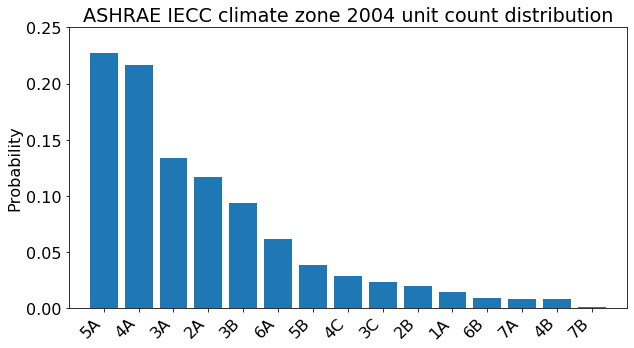

climate_zone,Option=1A,Option=2A,Option=2B,Option=3A,Option=3B,Option=3C,Option=4A,Option=4B,Option=4C,Option=5A,Option=5B,Option=6A,Option=6B,Option=7A,Option=7B
acs_count,0.014077,0.116704,0.019773,0.133932,0.093515,0.0236,0.216705,0.007782,0.028991,0.226862,0.038144,0.061535,0.009292,0.007949,0.001139


In [5]:
# Check the Map
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['climate_zone'],
                           legend_title='ASHRAE 169 Climate Zones', 
                           width=2*950, height=838,
                           title='Counties Tagged by ASHRAE 169 Climate Zones')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','ashrae_169_map.html'),auto_open=False)

# Calculate ASHRAE 169 Climate Zone Distribution
env = {'counts': 'acs_count',
       'x_variable': 'climate_zone',
       'title': 'ASHRAE IECC climate zone 2004 unit count distribution',
       'figsize': (10,5),
       'y_max': 0.25,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.1}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create the distribution of housing units by ASHRAE 169 climate zone.
tsv_maker.create_ashrae_169_climate_zone_tsv()

# Display 
display(tsv_maker.ashrae_169_cz_df)

### County.tsv

In [6]:
# Unit Counts by county
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['acs_count'],
                           binning_endpoints=[1e3, 1e4, 1e5, 1e6],
                           legend_title='Housing Units', 
                           width=2*950, height=838,
                           title='Unit Counts ACS 2016 5-year Estimate')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','county_unit_count_map.html'),auto_open=False)

# Create the distribution of housing units by county.
tsv_maker.create_county_tsv()

# Display
display(tsv_maker.county_df.head(10))

long_name,Dependency=ASHRAE IECC Climate Zone 2004,"Option=AL, Autauga County","Option=AL, Baldwin County","Option=AL, Barbour County","Option=AL, Bibb County","Option=AL, Blount County","Option=AL, Bullock County","Option=AL, Butler County","Option=AL, Calhoun County","Option=AL, Chambers County",...,"Option=WY, Niobrara County","Option=WY, Park County","Option=WY, Platte County","Option=WY, Sheridan County","Option=WY, Sublette County","Option=WY, Sweetwater County","Option=WY, Teton County","Option=WY, Uinta County","Option=WY, Washakie County","Option=WY, Weston County"
0,1A,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2A,0.000000,0.006922,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2B,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3A,0.001273,0.000000,0.000662,0.000503,0.001337,0.00025,0.000556,0.00299,0.000948,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,3B,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,3C,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4A,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,4B,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,4C,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,5A,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### PUMA.tsv
The Public Use Microdata Areas (PUMA) are show in the image below.  According to <http://proximityone.com/puma/pumas20101b.gif>.

    The 2,378 2010 vintage PUMAs are developed using Census 2010 geography, cover the U.S. wall-to-wall, conform to state boundaries, and where possible are comprised of whole Census 2010 census tracts. The first use of the 2010 vintage PUMAs is with the ACS 2012 PUMS and 1-year summary statistic data. Use the interactive table in this section to examine 2010 PUMAs and PUMA component area geography.

    While PUMS files contain data for respondents across the U.S., most lower level geography are not identified by any variables in the PUMS files. The PUMA is the most detailed unit of geography identified in the PUMS files.

    PUMAs are special non-overlapping areas that partition each state into contiguous geographic units containing no fewer than 100,000 people each. 2010 PUMAs were built on census tracts, and cover the entirety of the United States and Puerto Rico.

<img src="references/pumas20101b.gif" alt="drawing" width="750"/>




In [7]:
# Create the distribution of housing units by PUMA.
tsv_maker.create_puma_tsv()

display(tsv_maker.puma_df)

puma_tsv,Dependency=County,"Option=AL, 00100","Option=AL, 00200","Option=AL, 00301","Option=AL, 00302","Option=AL, 00400","Option=AL, 00500","Option=AL, 00600","Option=AL, 00700","Option=AL, 00800",...,"Option=WV, 00900","Option=WV, 01000","Option=WV, 01100","Option=WV, 01200","Option=WV, 01300","Option=WY, 00100","Option=WY, 00200","Option=WY, 00300","Option=WY, 00400","Option=WY, 00500"
0,"AL, Autauga County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"AL, Baldwin County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"AL, Barbour County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"AL, Bibb County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"AL, Blount County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,"WY, Sweetwater County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3104,"WY, Teton County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3105,"WY, Uinta County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3106,"WY, Washakie County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


## Census mapping characteristics
The definitions of the sensus regions and census divisions were taken from https://www2.census.gov/geo/pdfs/maps-data/maps/reference/us_regdiv.pdf.

<img src="references/US_census_regions_census_divisions.png" alt="drawing" width="600"/>

This section creates 3 housing characteristics files.

1. State
2. Census Region
3. Census Division

### State.tsv

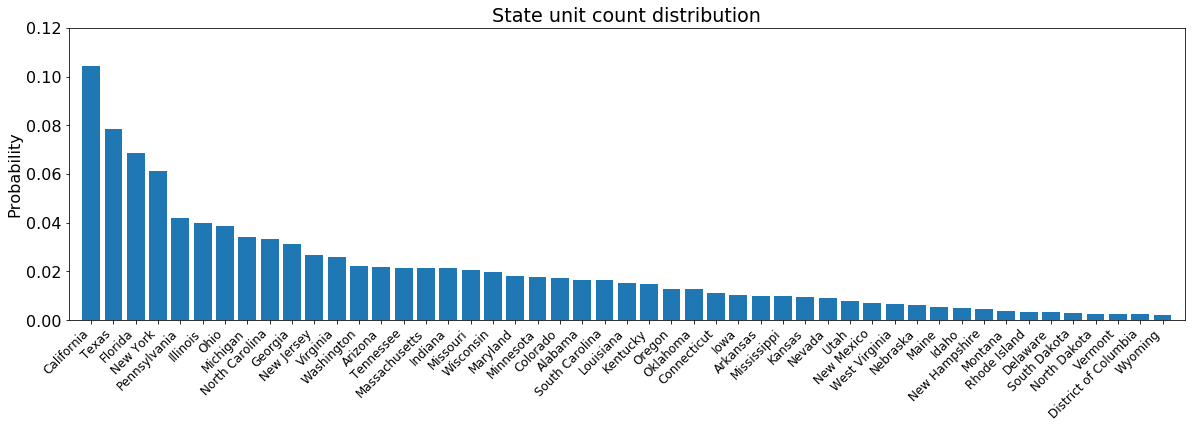

state_abbr,Dependency=County,Option=AL,Option=AR,Option=AZ,Option=CA,Option=CO,Option=CT,Option=DC,Option=DE,Option=FL,...,Option=SD,Option=TN,Option=TX,Option=UT,Option=VA,Option=VT,Option=WA,Option=WI,Option=WV,Option=WY
0,"AL, Autauga County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"AL, Baldwin County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"AL, Barbour County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"AL, Bibb County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"AL, Blount County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,"WY, Sweetwater County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3104,"WY, Teton County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3105,"WY, Uinta County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3106,"WY, Washakie County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [8]:
# Check the Map
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['state_name'],
                           legend_title='State Name', 
                           width=2*950, height=838,
                           title='Counties Tagged by State')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','state_map.html'),auto_open=False)

# Calculate State Distribution
env = {'counts': 'acs_count',
       'x_variable': 'state_name',
       'title': 'State unit count distribution',
       'figsize': (20,7),
       'y_max': 0.12,
       'xlabel_fontsize': 12,
       'bottom_pad': 0.3}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create the distribution of housing units by states.
tsv_maker.create_state_tsv()

# Display
display(tsv_maker.state_df)

###  Create Census Division.tsv

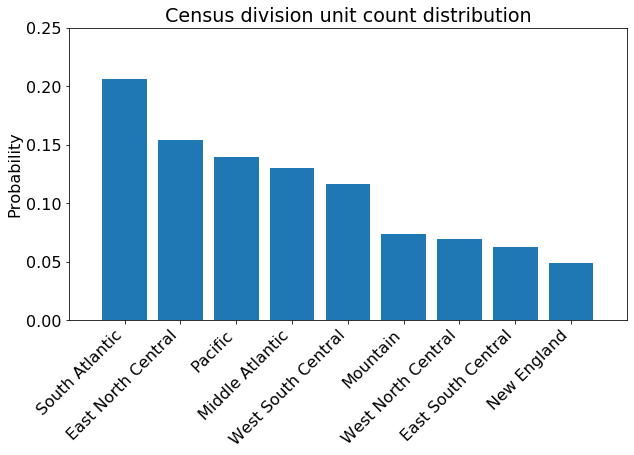

division_name,Dependency=State,Option=East North Central,Option=East South Central,Option=Middle Atlantic,Option=Mountain,Option=New England,Option=Pacific,Option=South Atlantic,Option=West North Central,Option=West South Central
0,CT,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,MA,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,ME,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,NH,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,RI,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
5,VT,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,NJ,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,NY,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,PA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,IL,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
# Check the map
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['division_name'],
                           legend_title='Census Division', 
                           width=2*950, height=838,
                           title='Counties Tagged by Census Division')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','census_division_map.html'),auto_open=False)

# Calculate Census Division Distribution
env = {'counts': 'acs_count',
       'x_variable': 'division_name',
       'title': 'Census division unit count distribution',
       'figsize': (10,7),
       'y_max': 0.25,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.3}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create a mapping housing characteristic that maps states to census divisions
tsv_maker.create_census_division_tsv()

# Display
display(tsv_maker.census_division_df.head(10))

### Census Region.tsv

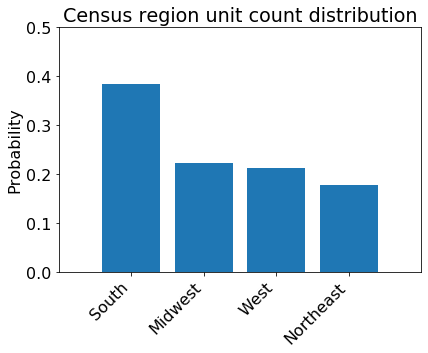

region_name,Dependency=Census Division,Option=Midwest,Option=Northeast,Option=South,Option=West
0,Middle Atlantic,0.0,1.0,0.0,0.0
1,New England,0.0,1.0,0.0,0.0
2,East North Central,1.0,0.0,0.0,0.0
3,West North Central,1.0,0.0,0.0,0.0
4,East South Central,0.0,0.0,1.0,0.0
5,South Atlantic,0.0,0.0,1.0,0.0
6,West South Central,0.0,0.0,1.0,0.0
7,Mountain,0.0,0.0,0.0,1.0
8,Pacific,0.0,0.0,0.0,1.0


In [10]:
# Check the map
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['region_name'],
                           legend_title='Census Region',
                           width=2*950, height=838,
                           title='Counties Tagged by Census Region')
fig.layout.template = None

# Calculate the Census Region Distribution
env = {'counts': 'acs_count',
       'x_variable': 'region_name',
       'title': 'Census region unit count distribution',
       'figsize': (6.5,5),
       'y_max': 0.5,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.2}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create a mapping housing characteristic that maps states to census divisions
tsv_maker.create_census_region_tsv()

# Display
display(tsv_maker.census_region_df.head(10))

## Other Spatial Characteristics

Using the dataset developed, other mapping housing characteristics can be developed.

1. Location Region
2. Building America Climate Zone
3. ISO/RTO Region
4. Location EPW

### Location Region.tsv

In the location region housing characteristic  the CR refers to “Custom Region”, which is based on RECS 2009 reportable domains aggregated into groups with similar climates; see the entire custom region map.

<img src="references/custom_region_map.png" alt="drawing" width="600"/>

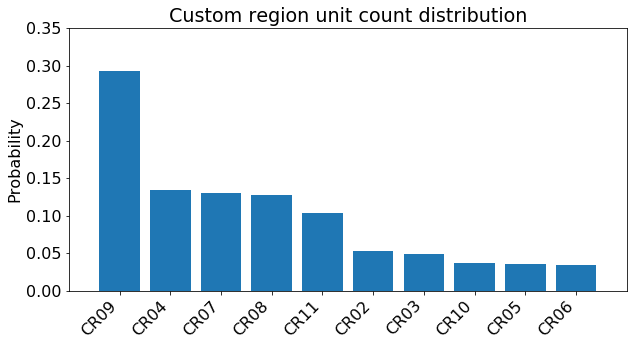

custom_region,Dependency=State,Option=CR02,Option=CR03,Option=CR04,Option=CR05,Option=CR06,Option=CR07,Option=CR08,Option=CR09,Option=CR10,Option=CR11
0,AL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,AR,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,AZ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,CA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,CO,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CT,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,DC,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
7,DE,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
8,FL,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,GA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [11]:
# Check the County/Custom Region Definitions
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['custom_region'],
                           legend_title='Custom Region', 
                           width=2*950, height=838,
                           title='Counties Tagged by Custom Region')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','custom_region_map.html'),auto_open=False)

# Calculate the Custom Region Distribution
env = {'counts': 'acs_count',
       'x_variable': 'custom_region',
       'title': 'Custom region unit count distribution',
       'figsize': (10,5),
       'y_max': 0.35,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.15}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create the location region tsv
tsv_maker.create_location_region_tsv()

# Display
display(tsv_maker.location_region_df.head(10))

### Building America Climate Zone.tsv

This housing characteristic uses the county specification of Building America climate zones (https://www.energy.gov/sites/prod/files/2015/10/f27/ba_climate_region_guide_7.3.pdf). 

M.C. Baechler, T.L. Gibride, P.C. Cole, M.G. Hefty, K. Ruiz. (2015) "High-Performance Home Technologies: Guilde to Determining Climate Regions by County." Building America Best Bractices Series, **Volume 7.3**, PNNL-17211 Rev. 3.

<img src="references/Building America Climate Zone Map.jpg" alt="drawing" width="750"/>

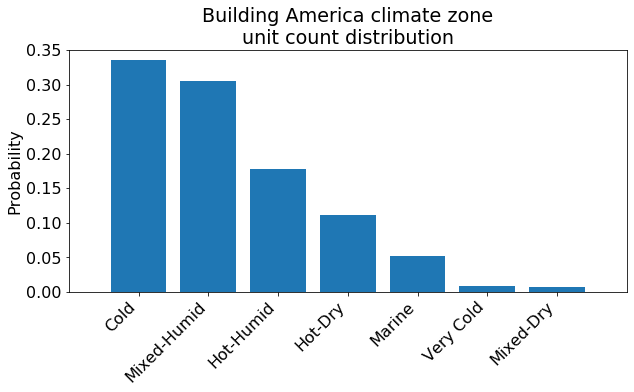

ba_climate_zone,Dependency=County,Option=Cold,Option=Hot-Dry,Option=Hot-Humid,Option=Marine,Option=Mixed-Dry,Option=Mixed-Humid,Option=Very Cold
0,"AL, Autauga County",0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,"AL, Baldwin County",0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,"AL, Barbour County",0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,"AL, Bibb County",0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,"AL, Blount County",0.0,0.0,0.0,0.0,0.0,1.0,0.0
5,"AL, Bullock County",0.0,0.0,1.0,0.0,0.0,0.0,0.0
6,"AL, Butler County",0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,"AL, Calhoun County",0.0,0.0,0.0,0.0,0.0,1.0,0.0
8,"AL, Chambers County",0.0,0.0,0.0,0.0,0.0,1.0,0.0
9,"AL, Cherokee County",0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [12]:
# Check the County/Building America Climate Zone Definitions
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['ba_climate_zone'],
                           legend_title='BA Climate Zone', 
                           width=2*950, height=838,
                           title='Counties Tagged by Building America Climate Zone')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','building_america_climate_zone_map.html'),auto_open=False)

# Calculate the Building America Climate Zone Distribution
env = {'counts': 'acs_count',
       'x_variable': 'ba_climate_zone',
       'title': 'Building America climate zone\nunit count distribution',
       'figsize': (10,7),
       'y_max': 0.35,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.4}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create a mapping housing characteristic that maps counties to Building America climate zones
tsv_maker.create_building_america_climate_zone_tsv()

# Display
display(tsv_maker.ba_cz_df.head(10))

### ISO RTO Region.tsv
This housing characteristic maps counties to Independent System Operators (ISO) and Regional Transmision Organization (RTO) regions. Data here was gathered from EIA form 861. If there is no ISO or RTO for a particular county, then the region is None.

<https://www.eia.gov/electricity/data/eia861/>

**Acronyms**
- CAISO: California Independent System Operator
- ERCOT: Electric Reliability Council of Texas
- MISO: Midcontinent Independent System Operator
- NEISO: ISO New England
- PJM: Pennsylvania, Jersey, Maryland Interconnection
- SPP: Southwest Power Pool

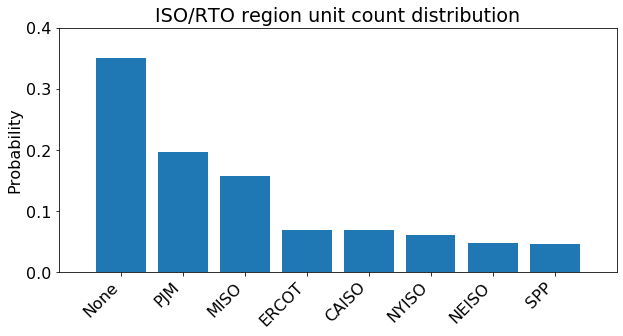

iso_zone,Dependency=County,Option=CAISO,Option=ERCOT,Option=MISO,Option=NEISO,Option=NYISO,Option=None,Option=PJM,Option=SPP
0,"AL, Autauga County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"AL, Baldwin County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,"AL, Barbour County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,"AL, Bibb County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,"AL, Blount County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5,"AL, Bullock County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6,"AL, Butler County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7,"AL, Calhoun County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,"AL, Chambers County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
9,"AL, Cherokee County",0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [13]:
# Check the County/Building America Climate Zone Definitions
fig = ff.create_choropleth(fips=tsv_maker.county_lookup_df['fips'],
                           values=tsv_maker.county_lookup_df['iso_zone'],
                           legend_title='ISO/RTO Region', 
                           width=2*950, height=838,
                           title='Counties Tagged by ISO/RTO Region')
fig.layout.template = None
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','iso_rto_map.html'),auto_open=False)

# Calculate the ISO/RTO Distribution
env = {'counts': 'acs_count',
       'x_variable': 'iso_zone',
       'title': 'ISO/RTO region unit count distribution',
       'figsize': (10,5),
       'y_max': 0.4,
       'xlabel_fontsize': 16,
       'bottom_pad': 0.2}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create a mapping housing characteristic that maps counties to ISO/RTO regions
tsv_maker.create_iso_rto_region_tsv()

# Display
display(tsv_maker.iso_rto_df.head(10))

### Location.tsv

The previous version of the housing characteristic was loosely NSRDB grid cells and census tract definitions of the housing units in the tracts. Looking at ASHRAE 169 and the building America Climate zones. They are both defined by counties. The Location housing characteristic is updated to only be a county map instead of the previous fractional county description. 

#### Data sources

1. AMI_MF.tsv.gz: pulled down using buildstockdb for the fractional weather station county mapping
2. resstock_epws.csv: from buildstockdb that summarizes details of the weather stations
3. CenPop2010_Mean_CO.csv: A population centroid of each county from U.S. Census Bureau (https://www2.census.gov/geo/docs/reference/cenpop2010/county/CenPop2010_Mean_CO.txt)

#### Assign the weather station regions
Previously the counties were fractionally assigned to multiple weather stations. The assignment was based on NSRDB grid cells spatial distance and elevation. In this update the fractions are replaced so that a county is fully allocated to a weather station. The assignment of a county to a weather station is based on 1) ASHRAE 169 climate zone number and 2) geospatial distance.

Lets define set of weather stations $W \in \mathbb{N}^{n_w}$ and a set of counties $C \in \mathbb{N}^{n_c}$. $n_w$ is the number of weather stations. $n_c$ is the number of counties. Every weather station has an assigned ASHRAE 169 climate zone.

$Z_w = \{Z_w(j) \in \mathbb{N} \hspace{2mm} | \hspace{2mm} 1 \le Z_w(j) \le 7 \} $ and $j=1:n_w$.

Similarly, every county has an assigned ASHRAE 169 climate zone number. 

$Z_c = \{Z_c(i) \in \mathbb{N} \hspace{2mm}| \hspace{2mm} 1 \le Z_c(i) \le 7 \} $ and $i=1:n_c$.

Based on the previous definition of the weather regions, there is a subset, $L$, of $W$ assinged to each county.

($L(i) \in \mathbb{N}^{n(i)}) \subset W \hspace{2mm} \forall \hspace{2mm} C(i), \hspace{2mm} i=1:n_c$

Where $n(i)$ is the number of weather stations that are in county $i$. For each station, $L(i)(j)$, and county, $C(i)$, there is a geospatial distance between them.

$D=f\left[L(i)(j),C(i)\right] \hspace{2mm} for \hspace{2mm} i=1:n_c, \hspace{2mm} j=1:n(i)$ 

The weather station, $\mathcal{L(i)}$, for a given county is determined by the following relation that weights the geospatial distance with the correct ASHRAE 169 climate zone.

$\mathcal{L(i)} = \min_{j \in 1: n(i)}\left[\left(\lvert Z_w[L(i)(j)] - Z_c(i)) \rvert + 1\right)D[L(i)(j),C(i)]\right]$

#### Creating the county to weather station lookup table
A version of this table exists on s3 and should be pulled down when downloading the data upon the creation of a `tsv_maker` object. If the table needs to be recreated, the `tsv_maker.create_county_to_location_lookup()` function can be used to create the table.

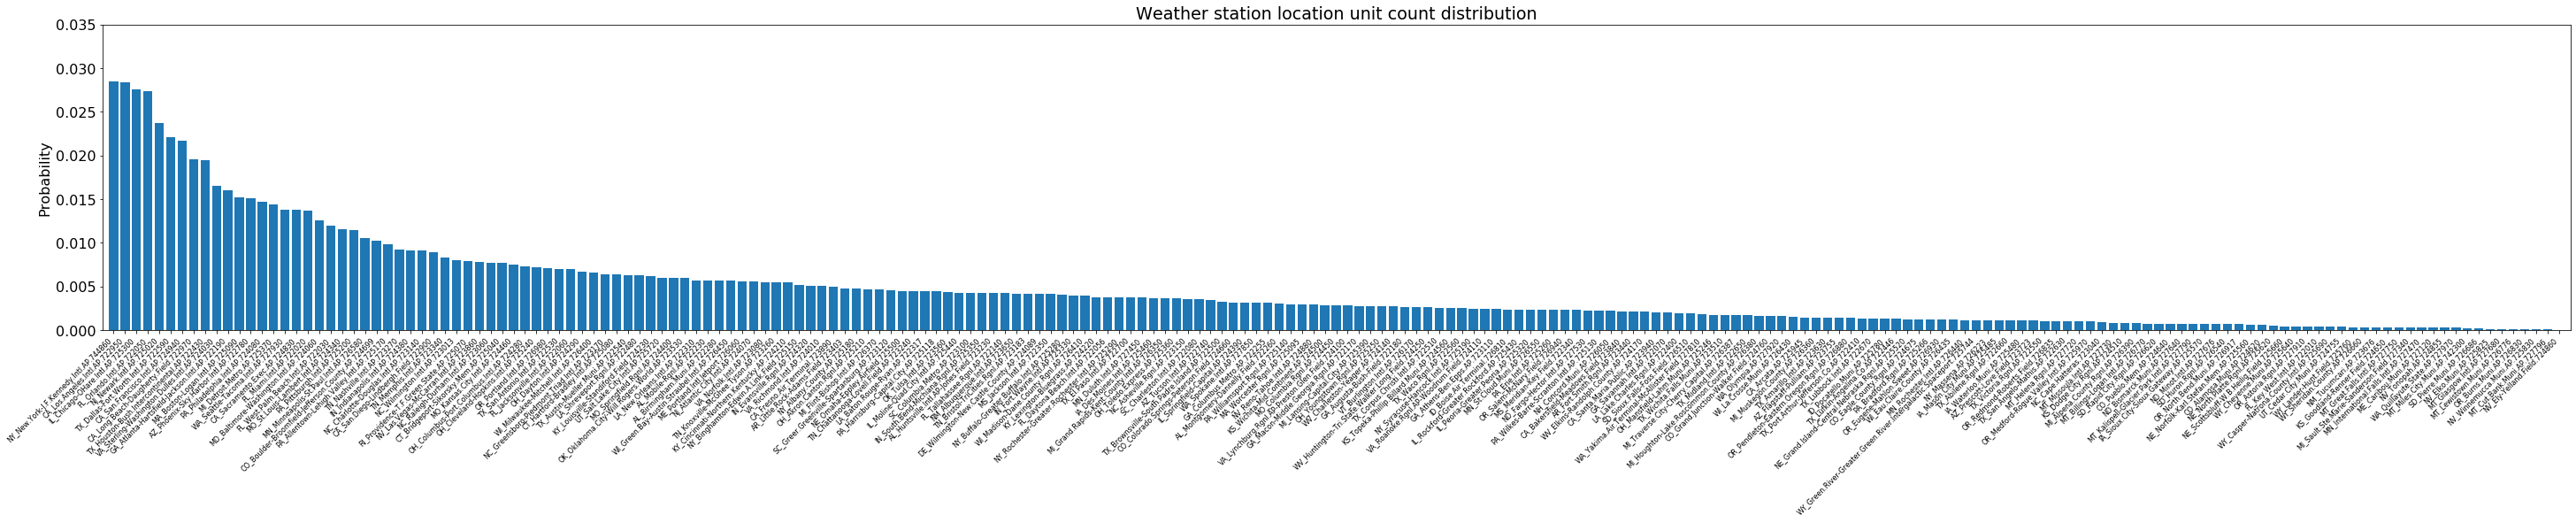

location,Dependency=County,Option=AL_Birmingham.Muni.AP.722280,Option=AL_Huntsville.Intl.AP-Jones.Field.723230,Option=AL_Mobile-Rgnl.AP.722230,Option=AL_Montgomery-Dannelly.Field.722260,Option=AR_Fort.Smith.Rgnl.AP.723440,Option=AR_Little.Rock-Adams.Field.723403,Option=AZ_Flagstaff-Pulliam.AP.723755,Option=AZ_Phoenix-Sky.Harbor.Intl.AP.722780,Option=AZ_Prescott-Love.Field.723723,...,Option=WI_Madison-Dane.County.Rgnl.AP.726410,Option=WI_Milwaukee-Mitchell.Intl.AP.726400,Option=WV_Charleston-Yeager.AP.724140,Option=WV_Elkins-Randolph.County.AP.724170,Option=WV_Huntington-Tri.State.Walker.Long.Field.724250,Option=WY_Casper-Natrona.County.Intl.AP.725690,Option=WY_Cheyenne.Muni.AP.725640,Option=WY_Green.River-Greater.Green.River.Intergalactic.Spaceport.725744,Option=WY_Lander-Hunt.Field.725760,Option=WY_Sheridan.County.AP.726660
0,"AL, Autauga County",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,"AL, Baldwin County",0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,"AL, Barbour County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,"AL, Bibb County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,"AL, Blount County",1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,"WY, Sweetwater County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3104,"WY, Teton County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3105,"WY, Uinta County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3106,"WY, Washakie County",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
# Load the lookup table for plotting
county_location_df = pd.read_csv(os.path.join('various_datasets','spatial_data','location_to_county.csv'))

# Create Map
## Create a random color Scheme
random_color_scheme = cl.interp( cl.scales['11']['div']['Spectral'], len(county_location_df) )
random.seed(0)
random.shuffle( random_color_scheme )

## Check the County/Building America Climate Zone Definitions
fig = ff.create_choropleth(fips=county_location_df['fips'],
                           values=county_location_df['location'],
                           legend_title='Location', 
                           title='County Tagged Locations',
                           width=2*950, height=2*830,
                           colorscale=random_color_scheme)
fig.layout.template = None
fig.update_layout(legend=dict(x=.5, y=0))
fig.update_layout(legend_orientation="h")
fig.update_layout(paper_bgcolor='rgba(0,0,0,0)')
fig.update_layout(plot_bgcolor='rgba(0,0,0,0)')

plotly.offline.plot(fig, filename=os.path.join('images','location_county_map.html'),auto_open=False)

# Calculate the Location Distribution
env = {'counts': 'acs_count',
       'x_variable': 'location',
       'title': 'Weather station location unit count distribution',
       'figsize': (50,10),
       'y_max': 0.035,
       'xlabel_fontsize': 8,
       'bottom_pad': 0.4}
df = tsv_maker.county_lookup_df[[env['x_variable'],env['counts']]].groupby(env['x_variable']).sum().reset_index()

# Plot Histogram
histogram_plot(df,env)

# Create a mapping housing characteristic that maps counties to ISO/RTO regions
tsv_maker.create_location_tsv()

display(tsv_maker.location_df)

# Write new housing characteristics to projects

In [15]:
# Write new housing characteristics to projects
if write_tf:
    tsv_maker.write_tsvs_to_projects()

../../project_multifamily_beta/housing_characteristics/ASHRAE IECC Climate Zone 2004.tsv...
../../project_multifamily_beta/housing_characteristics/State.tsv...
../../project_multifamily_beta/housing_characteristics/Census Division.tsv...
../../project_multifamily_beta/housing_characteristics/Census Region.tsv...
../../project_multifamily_beta/housing_characteristics/Location Region.tsv...
../../project_multifamily_beta/housing_characteristics/ISO RTO Region.tsv...
../../project_multifamily_beta/housing_characteristics/Location.tsv...
../../project_multifamily_beta/housing_characteristics/Building America Climate Zone.tsv...
../../project_multifamily_beta/housing_characteristics/County.tsv...
../../project_multifamily_beta/housing_characteristics/PUMA.tsv...
